### IMDB REVIEWS SENTIMENT ANALYSIS
- 50 000 recenzija u obliku: recenzija, positive/negative
- dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
# importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

from sklearn.model_selection import train_test_split



## Loading dataset

In [2]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [3]:
# data exploration
print(movie_reviews.head())
movie_reviews.shape

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


(50000, 2)

In [4]:
# are there any null values
movie_reviews.isnull().values.any()

np.False_

<Axes: xlabel='sentiment', ylabel='count'>

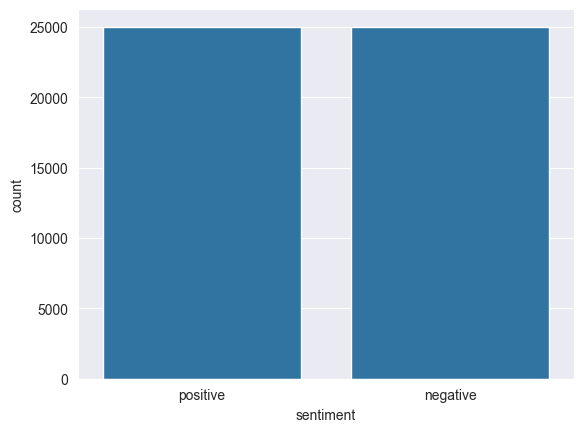

In [5]:
# distribution of positive/negative sentiments in dataset
import seaborn as sns
sns.countplot(x = "sentiment", data = movie_reviews)

## Data preprocessing


In [6]:
# take the review column, and print the third review
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

--> Uočavam da review sadrži html tag-ove, zagrade, točke...

In [7]:
# function for removing HTML tags
TAG_RE = re.compile(r'<[^>]+>') # regex for HTML tags
def remove_tags(text):
    return TAG_RE.sub(' ', text) # replaces all HTML tags with " "

In [8]:
import nltk
# downloading the stopwords dataset from NLTK
# contains common words that are usually ignored in text analysis ("the," "is," "and," "in,")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patricijamarijanovic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(sen):
    sentence = sen.lower() # to lowercase
    sentence = remove_tags(sentence) # remove HTML tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # remove multiple spaces

    # remove Stopwords
    # regex: r'\b(i|me|my|myself|we|our|ours|...) \b\s*'
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [10]:
# calling preprocess_text function on movie_reviews
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [11]:
# third review cleaned up
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [12]:
# converting sentiment to 0 and 1
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [13]:
# splitting the dataset into train and test
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preparing embedding layer

converts text data into numeric form

In [14]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train) # The tokenizer will assign each unique word a unique integer index
# builds an internal word index (a dictionary) that maps each unique word to a unique integer index

In [15]:
X_train = word_tokenizer.texts_to_sequences(X_train) # converts each sentence in X_train to a sequence of integers
X_test = word_tokenizer.texts_to_sequences(X_test)

In [16]:
# total number of unique words in your dataset
# .word_index is a dictionary (pairs of word and its index)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

90703

In [17]:
# padding all reviews to fixed length (100 words)
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
# tokenizer converts text into numbers, but they don't tell us anything about the meaning of words
# that's why we use GloVe - to get a vector for the meaning of words
# load GloVe word embeddings and create and Embeddings dictionary
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8") # each line contains a word followed by a sequence of numbers

for line in glove_file:
    records = line.split() # ['king', '0.215', '0.311', '-0.024', ...]
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32') # numpy array of numbers
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [19]:
# create embedding matrix having 100 columns
# containing 100-dimensional GloVe word embeddings for all words in our corpus

embedding_matrix = zeros((vocab_length, 100)) # contains GloVe vector for all unique words in our reviews
for word, index in word_tokenizer.word_index.items(): # iterate through all unique words
    embedding_vector = embeddings_dictionary.get(word) # get the GloVe vector for a specific word
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [20]:
embedding_matrix.shape

(90703, 100)

## Model training with SIMPLE NEURAL NETWORK

In [21]:
# sequential - layers of the network are in a sequence, one layer's output is another layer's input
snn_model = Sequential()

# input to the Embedding layer is a sequence of indices, not words
# After passing the indices through the Embedding layer, each index is mapped to a 100-dimensional vector
# These vectors are semantic (similar words will have similar representations in the embedding space)
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False) # the matrix is constant during training
snn_model.add(embedding_layer)

# embedding_layer output: for a 5-word sentence -> 5 x 100 matrix (each row represents the embedding for one word in the sentence)
# Flatten layer takes this 2D tensor with shape (5, 100) and reshapes it into a 1D array of size 5 * 100 = 500
snn_model.add(Flatten()) # to 1D

snn_model.add(Dense(1, activation='sigmoid')) # binary classification

In [22]:
# model compiling
# specifying how the model should be trained

snn_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
# optimizer - determines how the model's weights are adjusted during training
#           - minimizes the loss function (how far are we from the correct output) by adjusting the model's weights
# loss function - measures the difference between the model's predictions and the actual target values
# metrics - how well the model is performing and whether the accuracy is improving
#         - "accuracy" - correct/total
print(snn_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,070,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,070,300 (34.60 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,070,300 (34.60 MB)

None


In [23]:
# model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size = 200, epochs = 6, verbose = 1, validation_split = 0.2)

# batch_size - the number of training samples that will be passed through the model before the model's weights are updated
#            - processes 128 samples at a time, and then updates the weights
#            - Small batch size (e.g., 32) means frequent updates and more detailed learning but slower training time

# epochs -  how many times the model will pass through the ENTIRE training dataset

# verbose - how much information is displayed during training
# validation split - 80% of the data is used for training, 20% is set aside for validation

Epoch 1/6
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6469 - loss: 0.6219 - val_accuracy: 0.7538 - val_loss: 0.5098
Epoch 2/6
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.4527 - val_accuracy: 0.7619 - val_loss: 0.5007
Epoch 3/6
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.4057 - val_accuracy: 0.7657 - val_loss: 0.4952
Epoch 4/6
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.3842 - val_accuracy: 0.7646 - val_loss: 0.4994
Epoch 5/6
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - loss: 0.3701 - val_accuracy: 0.7632 - val_loss: 0.5114
Epoch 6/6
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3577 - val_accuracy: 0.7615 - val_loss: 0.5140


In [24]:
# prediction on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7434 - loss: 0.5420


In [25]:
# model performance
print('Test accuracy:', score[1])
print('Test score:', score[0])

Test accuracy: 0.7483999729156494
Test score: 0.5419409871101379


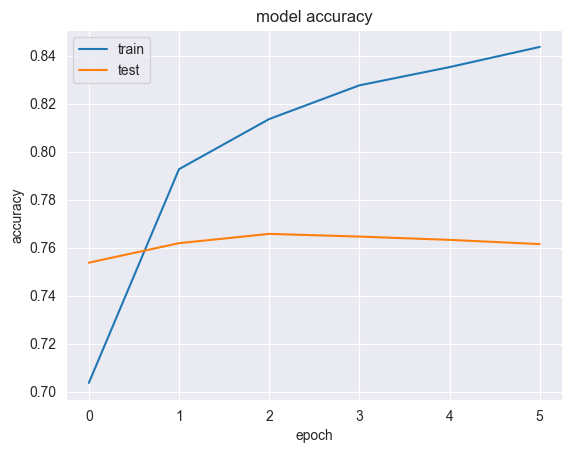

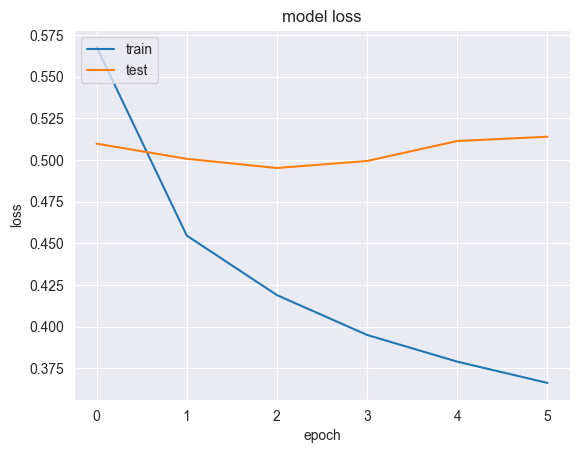

In [26]:
# model performance charts
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['accuracy'])
plt.plot(snn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model training with CONVOLUTIONAL NEURAL NETWORK (CNN)

- primarily used for 2D data classification (images)
- tries to find specific features in an image (1st layer), and then the initial detected features are joint together to form bigger features (2nd layer) --> the whole image is detected
- text data - we use 1D CNN-s


In [27]:
# neural network architecture
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation = 'relu'))
# 128 kernels (filters)
# 5 = kernel size (5 words at the time)
# detects local patterns or features in the sequence of words (e.g., certain word combinations or phrases)
# applies 128 different filters (feature detectors) to each sliding window of 5 words in the input sequence. Each filter produces a feature map -> capturing patterns

# pooling layer
# reduces dimensionality
# looks for the strongest activation - the most relevant pattern in text
cnn_model.add(GlobalMaxPooling1D())

cnn_model.add(Dense(1, activation='sigmoid'))

In [28]:
# model compiling

cnn_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,070,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,070,300 (34.60 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,070,300 (34.60 MB)

None


In [29]:
# model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size = 128, epochs = 6, verbose = 1, validation_split = 0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6986 - loss: 0.5636 - val_accuracy: 0.8326 - val_loss: 0.3798
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8565 - loss: 0.3410 - val_accuracy: 0.8465 - val_loss: 0.3469
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8821 - loss: 0.2923 - val_accuracy: 0.8510 - val_loss: 0.3431
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9122 - loss: 0.2358 - val_accuracy: 0.8429 - val_loss: 0.3525
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9392 - loss: 0.1933 - val_accuracy: 0.8560 - val_loss: 0.3355
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9530 - loss: 0.1603 - val_accuracy: 0.8539 - val_loss: 0.3372


In [30]:
# predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8551 - loss: 0.3397


In [31]:
# model performance
print('Test accuracy:', score[1])
print('Test score:', score[0])

Test accuracy: 0.8535000085830688
Test score: 0.34421733021736145


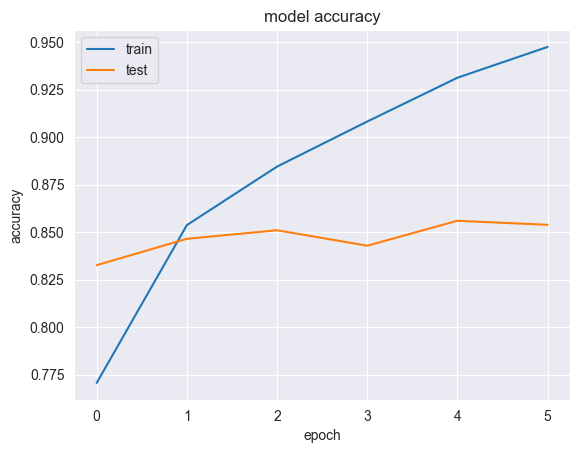

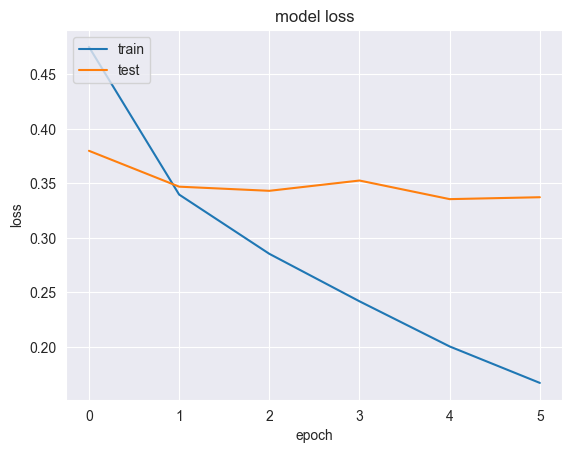

In [32]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Model training with LSTM (RNN)

- Recurrent Neural Network - proven to work well with sequential data

In [33]:
# neural network architecture

lstm_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix],  trainable=False)
lstm_model.add(embedding_layer)

# LSTM layer
# reads a sentence one word at a time
# remembers important words and patterns from earlier in the sentence - captures CONTEXT
# 128 = number of memory units (neurons) in the LSTM layer (Each unit acts like a small memory cell that helps the model remember important patterns from the input sequence)
# more units -> more memory capacity to learn patterns and long-term dependencies in the data

lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))


In [34]:
# model compiling
lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     9,070,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,070,300 (34.60 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,070,300 (34.60 MB)

None


In [35]:
# model training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size = 128, epochs = 6, verbose = 1, validation_split = 0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.6944 - loss: 0.5716 - val_accuracy: 0.7740 - val_loss: 0.4696
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.8028 - loss: 0.4372 - val_accuracy: 0.8334 - val_loss: 0.3877
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.8293 - loss: 0.3922 - val_accuracy: 0.8466 - val_loss: 0.3476
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.8560 - loss: 0.3420 - val_accuracy: 0.8457 - val_loss: 0.3539
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.8650 - loss: 0.3227 - val_accuracy: 0.8429 - val_loss: 0.3802
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.8712 - loss: 0.3103 - val_accuracy: 0.8670 - val_loss: 0.3204


In [36]:
# predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8647 - loss: 0.3255


In [37]:
# model performance
print('Test accuracy:', score[1])
print('Test score:', score[0])

Test accuracy: 0.8623999953269958
Test score: 0.3270726501941681


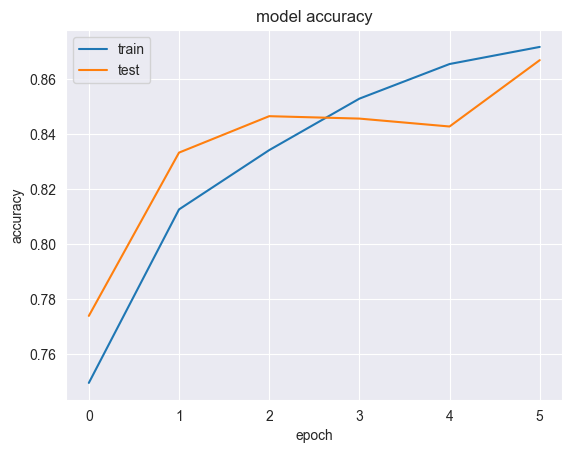

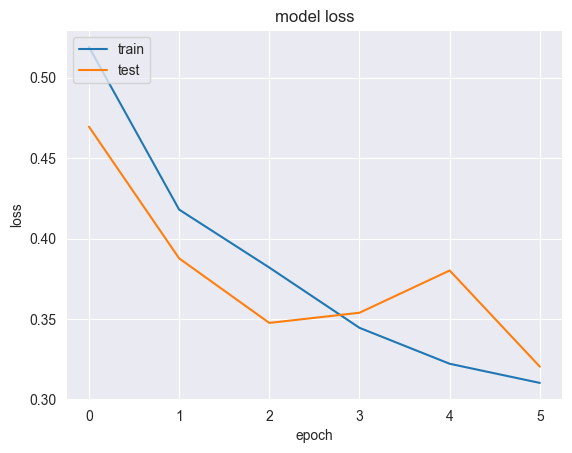

In [38]:
    # Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Making predictions on unseen IMDB data

In [39]:
dataset_unseen_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")
dataset_unseen_reviews.head()

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10


In [40]:
# preprocessing
unseen_reviews = dataset_unseen_reviews["Review Text"]

unseen_processed = []
for r in unseen_reviews:
    unseen_processed.append(preprocess_text(r))

In [41]:
print(unseen_processed[0])

intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie ma

In [42]:
# tokenising (with earlier trained tokeniser)
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# pooling instance to have maxlen of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [43]:
# passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


array([[0.9166313 ],
       [0.9914896 ],
       [0.29443562],
       [0.91203797],
       [0.97459126],
       [0.02137031]], dtype=float32)

In [44]:
# Writing model output file back to Google Drive

dataset_unseen_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(dataset_unseen_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(dataset_unseen_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(dataset_unseen_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(dataset_unseen_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,"Intelligent Movie.\nThis movie is obviously allegorical, a fascinating tale about AI, but it is mainly about manipulation and power. It isn't for those wanting action or spectacular CGI, the movie is aimed at people who like to think, rather than passively wait to be entertained. There are themes here not only about AI, but also about surveillance, with excellent points about how data about us is collected by phone companies, search engine companies, commercial operating systems makers and so on. The plot seems simple but isn't, it's extremely clever, with the protagonist playing games, trying to stay one step ahead of one another. This is a movie with perfectly consistent internal logic that plays out perfectly. Don't go in expecting too much, however, as I can see most people will not be satisfied by this movie, but for me, it does what it sets out to do brilliantly. Therefore I give at least 9/10. And most recent movies have been getting 5/10 from me. This movie succeeds where another recent movie about AI, Transcendence, I think it is called, failed (but it was an interesting failure). A third movie about AI, a Spanish movie called Eva, was also brilliant. Eva was more moving and this movie more philosophical. But both movies were perfect in their different ways. The AI's name in this movie, Ava, seems to be a nod to the title of the Spanish movie. As an aside, it's nice that no ""stars"" appeared in ""Ex Machina"" and ""Eva"", the casting was great. Of course there are several aspects of this movie that are unrealistic and often absurd. But because this is an allegorical movie, these are acceptable, because the movie is making points, rather than striving for realism. It's more of a fairytale than accurate portrayal.",9,9.2
1,Ex Machina,"Extraordinary and thought-provoking.\n'Ex machina' is surprisingly dense, more so than other titles Alex Garland has written, perhaps excepting only 'Annihilation.' The simple concept is given a definite narrative, but that narrative pointedly explores the very nature of thought, and perception, and further broaching the nature and ramifications of morality. This is a psychological thriller, and in fundamental construction and in minute rendering alike, it is more intense than any other feature in the genre that I can name offhand, so much so as to almost classify as horror. The movie emphasizes and plays on dire uncertainty of intent, motivation, and reality all the way through to the climax, and even then leaves us with a somewhat ambiguous ending. And from ordinary beginning to captivating ending, at every point 'Ex machina' is absolutely marvelous.\n\nOf any performance I've seen from Oscar Isaac, none have been nearly so forceful as his portrayal of Nathan, exhibiting outstanding nuance and sharp personality in the realization of a man exceptionally intelligent, and exceptionally cruel and conniving. I'm not especially familiar with Domhnall Gleeson, but the Irish actor demonstrates admirable range and poise readily matching the same traits that are more immediately notable in his costars. And with that said - certainly not to count out anyone else involved - Alicia Vikander is phenomenal as Ava, showing a careful exactness to every motion and expression befitting the character, and impressing with her skills in the most subtle of ways.\n\nI love the score composed between Ben Salisbury and Geoff Barrow, lending to the pensive unease about the film and building to a great crescendo at the precise appropriate moments. The sound design is exquisite - soft and unobtrusive, and with those qualities denoting both the meticulous craft of the feature, and the highly advanced status of Ava. So it is, too, with the special effects; to read a little bit of the production history informs of the substantial effort made to ensure every element of Nathan's creation was visualized with the utmost possibility of realism. And I think t

In [47]:
print(dataset_unseen_reviews["Review Text"][3], dataset_unseen_reviews["IMDb Rating"][3], dataset_unseen_reviews["Predicted Sentiments"][3])

Had Great Potential.
This movie is one of the countless that have come out of Hollywood that had great potential.

However, like so many personalities in Hollywood, it sold it's soul for a cheap finish.

There were some beautiful ideas in this movie, and it could of been great.

However, the producers chose to go for the cheap thriller effect, instead of exploring what truly makes us human or machine. Conceived, written, and produced by idiots with now soul.

Don't waste your time.

The only redeeming part of this movie was when the dweeb gets sent to the sticks, and is surprised when his smartphone tell him that there was no signal. The producers and writers of this piece of crap obviously had no signal also. 1 9.1
